### LSB index 
## AMIE manus period 

period : 1 Oct 2011 - 31 March 2012


In [4]:
import glob 
import pandas as pd

import xarray as xr

In [38]:
from dask_jobqueue import SLURMCluster
import matplotlib.pyplot as plt 
import glob
import os
import xarray as xr 
import pandas as pd
import numpy as np


from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    job_name="Climt1",          # --job-name
    cores=12,                     # Number of cores per task (adjust if needed)
    processes=6,                 # One process per task
    memory="100GB",               # --mem
    walltime="01:15:00",         # --time
    queue="med",               # --partition
    log_directory=".",           # Logs will be saved to the current directory
)


from dask.distributed import Client


cluster.scale(jobs=10)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.42.239.61:8787/status,
Dashboard: http://10.42.239.61:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.42.239.61:37603,Workers: 0
Dashboard: http://10.42.239.61:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [2]:
def create_dft(in_dir,arm_data=True):
    files = glob.glob(in_dir+os.sep+'*.nc')
    if len(files) == 0:
        files = glob.glob(in_dir+os.sep+'*.cdf')
        if len(files) == 0:
            raise Exception('No files Found')
        else:
            pass
    else:
        pass
    
    dft = pd.DataFrame(files,columns=['filepath'])
    dft['filename'] = dft['filepath'].str.split(os.sep).str[-1]
    
    if arm_data:
        dft['datetime'] = pd.to_datetime(dft['filename'].str.split(
            '.',
            expand=True).iloc[:, 2] + dft['filename'].str.split(
                '.',  expand=True).iloc[:, 3],format='%Y%m%d%H%M%S')


    return dft

In [ ]:
launch_stat = 'sonde_with_data.csv'



dft_sonde = pd.read_csv(launch_stat)

dft_sonde['date'] = pd.to_datetime(dft_sonde['date'])


dft_sonde.set_index('date',inplace=True)

inter_data = '/home1/nalex2023/Datasets/interpsonde_manus'

dft_inter = create_dft(inter_data)

dft_inter['datetime'] = dft_inter['datetime'].dt.round('H')
dft_inter.set_index('datetime',inplace=True)

dft_inter_sub = pd.merge(dft_sonde,dft_inter,left_index=True,
                         right_index=True,how='inner')

NameError: name 'pd' is not defined

In [41]:

interp_dset = xr.open_mfdataset(dft_inter_sub['filepath_y'].values,parallel=True,combine='by_coords',chunks={'time':100})



In [1]:
interp_dset

NameError: name 'interp_dset' is not defined

In [3]:
era_data = glob.glob('/home1/nalex2023/Datasets/era5_manus/*.nc')
dft_era = pd.DataFrame(era_data, columns=['files'])


dft_era['year'] = dft_era['files'].str.split('_').str[-1].str[:4]
dft_era['month'] = dft_era['files'].str.split('_').str[-1].str[4:6].astype(int)



In [4]:
amie_period = pd.date_range(start='2011-10-01', end='2012-03-31', freq='D')

dft_era_amie = dft_era[(dft_era['year'].isin(amie_period.year.astype(str))) & (dft_era['month'].isin(amie_period.month))]


era_dset_amie = xr.open_mfdataset(dft_era_amie['files'].values, combine='by_coords').sel(pressure_level=slice(1000,800),latitude=slice(-1,-3),longitude=slice(146,148))



In [5]:

era_dset_amie_diurnal = era_dset_amie.groupby('valid_time.hour').mean().sel(pressure_level=1000).compute()

era_dset_amie_diurnal['u'] = era_dset_amie_diurnal['u'].roll(hour=10)
era_dset_amie_diurnal['v'] = era_dset_amie_diurnal['v'].roll(hour=10)

era_dset_amie_diurnal['speed'] = mpcalc.wind_speed(era_dset_amie_diurnal.u,era_dset_amie_diurnal.v)
era_dset_amie_diurnal['direction'] = mpcalc.wind_direction(era_dset_amie_diurnal.u,era_dset_amie_diurnal.v)



NameError: name 'mpcalc' is not defined

(<Figure size 2000x1000 with 24 Axes>,
 array([[<GeoAxes: title={'center': '12 AM'}>,
         <GeoAxes: title={'center': '1 AM'}>,
         <GeoAxes: title={'center': '2 AM'}>,
         <GeoAxes: title={'center': '3 AM'}>,
         <GeoAxes: title={'center': '4 AM'}>,
         <GeoAxes: title={'center': '5 AM'}>],
        [<GeoAxes: title={'center': '6 AM'}>,
         <GeoAxes: title={'center': '7 AM'}>,
         <GeoAxes: title={'center': '8 AM'}>,
         <GeoAxes: title={'center': '9 AM'}>,
         <GeoAxes: title={'center': '10 AM'}>,
         <GeoAxes: title={'center': '11 AM'}>],
        [<GeoAxes: title={'center': '12 PM'}>,
         <GeoAxes: title={'center': '1 PM'}>,
         <GeoAxes: title={'center': '2 PM'}>,
         <GeoAxes: title={'center': '3 PM'}>,
         <GeoAxes: title={'center': '4 PM'}>,
         <GeoAxes: title={'center': '5 PM'}>],
        [<GeoAxes: title={'center': '6 PM'}>,
         <GeoAxes: title={'center': '7 PM'}>,
         <GeoAxes: title={'center'

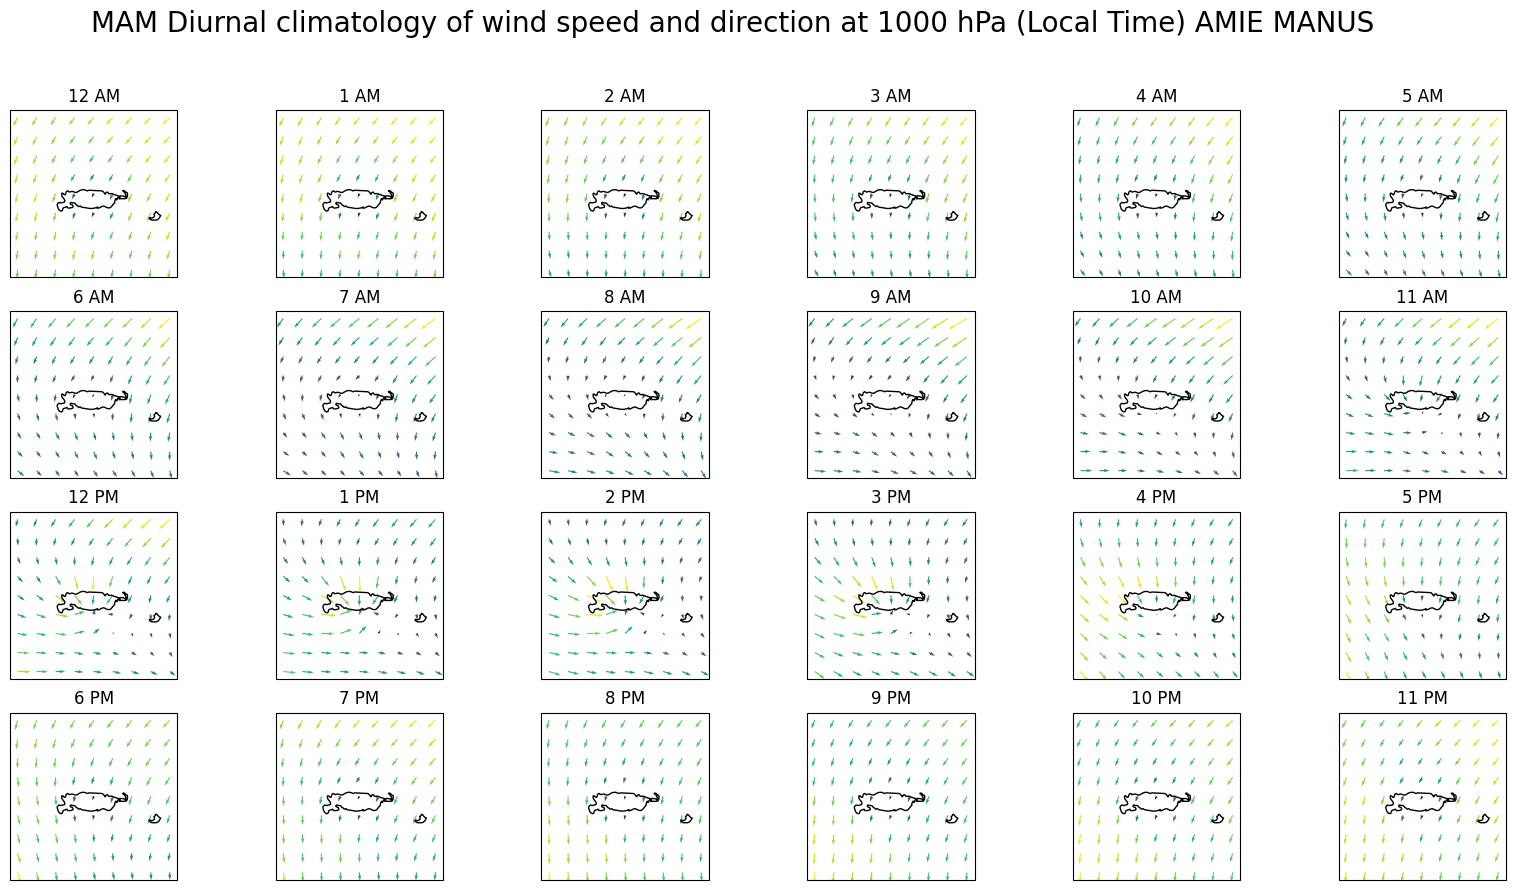

In [ ]:

import metpy.calc as mpcalc
import numpy as np
import metpy.units as units
import cartopy.crs as ccrs



def create_spatial_quiver(era_data_diurnal):
    fig , ax = plt.subplots(4,6,subplot_kw={'projection':ccrs.PlateCarree()},figsize=(20,10))
    axs = ax.flatten()
    for i in range(24):
        x = era_data_diurnal.longitude
        y = era_data_diurnal.latitude
        z = era_data_diurnal.speed.sel(hour=i)
        c = era_data_diurnal.direction.sel(hour=i)
        u = era_data_diurnal.u.sel(hour=i)
        v = era_data_diurnal.v.sel(hour=i)
        #era_data_diurnal.speed.sel(hour=i).plot(ax=axs[i],cmap='RdBu_r',transform=ccrs.PlateCarree())
        axs[i].quiver(x,y,u,v,z,transform=ccrs.PlateCarree())
        axs[i].coastlines()
        hour_in_ampm = i%12
        if hour_in_ampm == 0:
            hour_in_ampm = 12
        if i < 12:
            axs[i].set_title(f'{hour_in_ampm} AM')
        else:
            axs[i].set_title(f'{hour_in_ampm} PM')
    
    fig.suptitle('MAM Diurnal climatology of wind speed and direction at 1000 hPa (Local Time) AMIE MANUS',fontsize=20)

    return fig,ax


create_spatial_quiver(era_dset_amie_diurnal)


In [6]:
interp_data = '/home1/nalex2023/Datasets/interpsonde_manus/'

dft_interp = pd.DataFrame(glob.glob(interp_data+'*.nc'),columns=['files'])

dft_interp['year'] = dft_interp['files'].str.split(os.sep).str[-1].str.split('_').str[0]


dft_sub = dft_interp[dft_interp['year'].isin(amie_period.year.astype(str))]

dset_interp = xr.open_mfdataset(dft_sub['files'].values,combine='by_coords').compute()


Text(147.47, -2.06, 'ARM Manus')

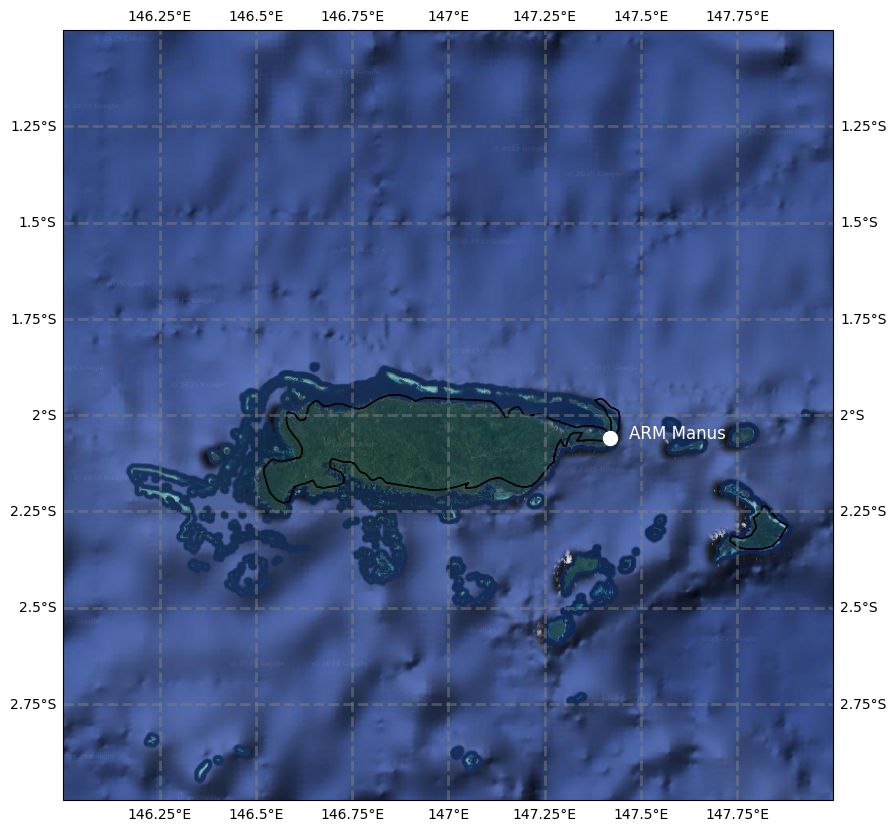

In [15]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fig,ax = plt.subplots(1,1,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()})


# add the tick lines/ gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

ax.set_extent([146,148,-3,-1],crs=ccrs.PlateCarree())   

ax.coastlines() 
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
from cartopy.io.img_tiles import GoogleTiles
# add satellite imagery cartopy 

# tile = http://mt0.google.com/vt/lyrs=s&hl=en&x={x}&y={y}&z={z}

terrain = GoogleTiles(style='satellite')

ax.add_image(terrain, 10)

arm_lat , arm_lon = -2.06, 147.42

ax.plot(arm_lon,arm_lat,marker='o',color='white',markersize=10,transform=ccrs.PlateCarree())

ax.text(arm_lon + 0.05,arm_lat,'ARM Manus',transform=ccrs.PlateCarree(),fontsize=12,color='white')

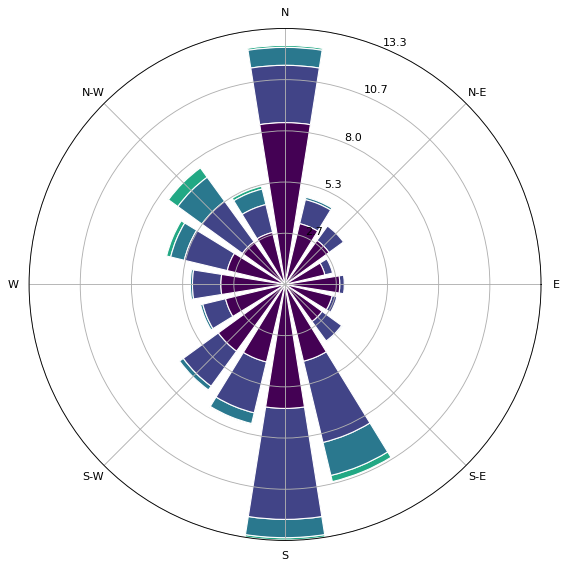

In [84]:
from windrose import WindroseAxes

wspd = mpcalc.wind_speed(dset_interp.u_wind,dset_interp.v_wind).sel(height=0,method='nearest').dropna('time').values

wdir = mpcalc.wind_direction(dset_interp.u_wind,dset_interp.v_wind).sel(height=0,method='nearest').dropna('time').values

ax = WindroseAxes.from_ax()

ax.bar(wdir,wspd, normed=True, opening=0.8, edgecolor='white')
# set xticks as the angles


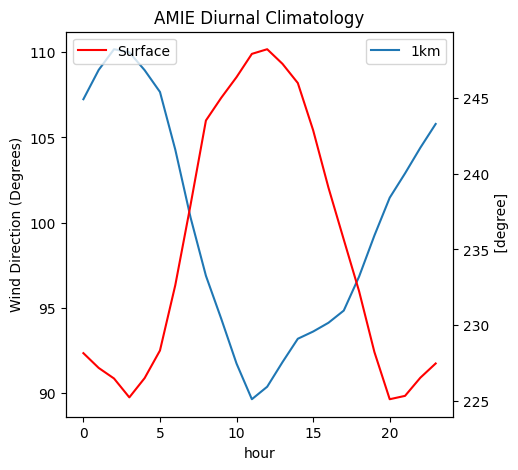

In [102]:

dset_interp_diurnal = dset_interp.groupby('time.hour').mean().compute()

wspd_diurnal1 = mpcalc.wind_speed(dset_interp_diurnal.u_wind,dset_interp_diurnal.v_wind).sel(height=1,method='nearest')
wdir_diurnal1 = mpcalc.wind_direction(dset_interp_diurnal.u_wind,dset_interp_diurnal.v_wind).sel(height=1,method='nearest')

wdir_diurnal0 = mpcalc.wind_direction(dset_interp_diurnal.u_wind,dset_interp_diurnal.v_wind).sel(height=0,method='nearest')
wspd_diurnal0 = mpcalc.wind_speed(dset_interp_diurnal.u_wind,dset_interp_diurnal.v_wind).sel(height=0,method='nearest')

fig,ax = plt.subplots(figsize=(5,5))
wdir_diurnal1.plot(ax=ax,label='1km')

ax2 = ax.twinx()

wdir_diurnal0.plot(ax=ax2,color='red',label='Surface')

ax.set_ylabel('Wind Direction (Degrees)')

ax.set_title('AMIE Diurnal Climatology')

ax2.set_title('')
ax.legend()
ax2.legend(loc='upper left')



AttributeError: PathCollection.set() got an unexpected keyword argument 'normed'

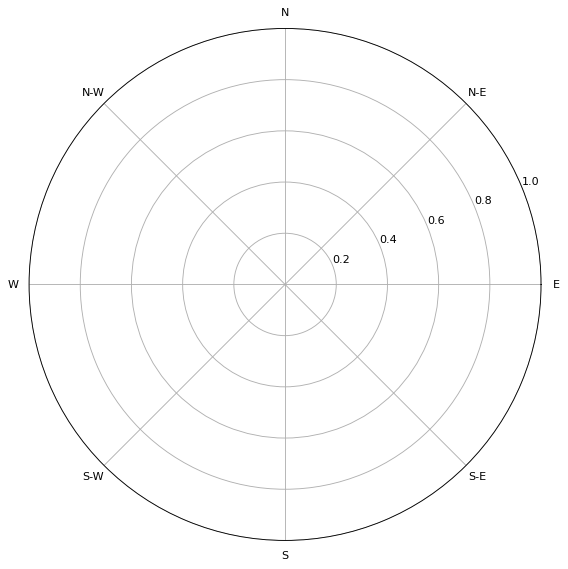

In [88]:
ax = WindroseAxes.from_ax()

ax.scatter(wdir_diurnal1,wspd_diurnal1, normed=True, edgecolor='white',color='red',label='1 km')